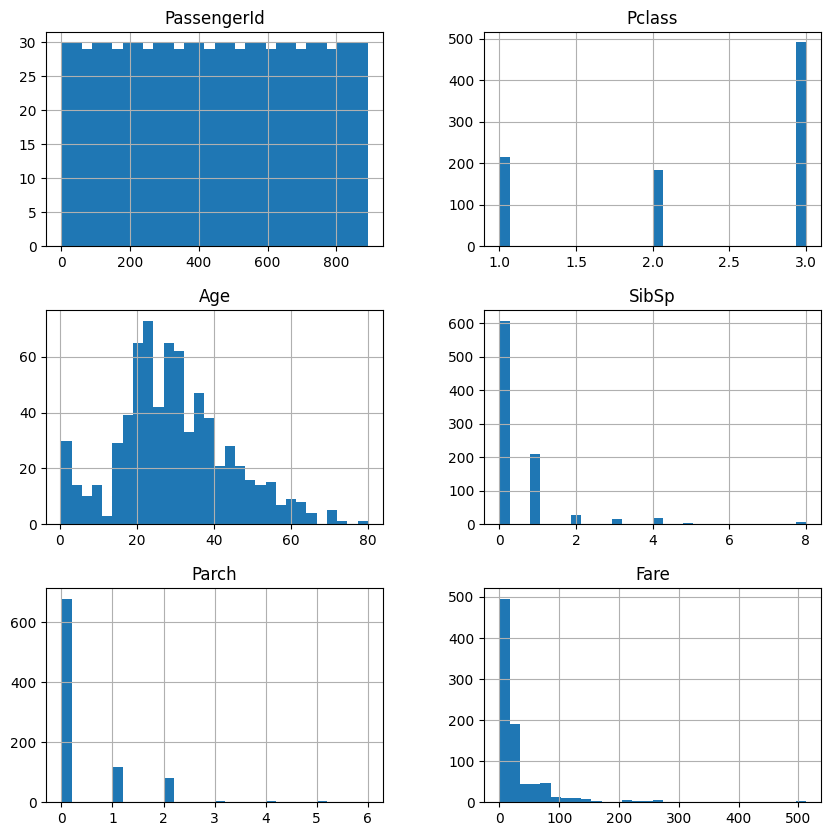

Data frame splitting completed.


In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
def read_csv (path):
    train_data = pd.read_csv(path)
    return train_data

train_data =  read_csv('train.csv')
train_data_num = train_data.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked','Survived'])
train_data_text = train_data.drop(columns=['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])
train_data_target = train_data['Survived']
corr_matrix = train_data_num.corr()
training_data = train_data.drop(["Survived"], axis=1)
train_data_num.hist(figsize=(10, 10), bins=30)
plt.show()
print("Data frame splitting completed.")

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_attributes = list(train_data_num)
text_attributes = list(train_data_text)

num_pipeline = Pipeline([  
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
    ('scaler', StandardScaler())
])

text_pipeline = Pipeline([
    ('impute_text', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

pre_processor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_attributes),
        ('text', text_pipeline, text_attributes)
    ],
)

print("Data preprocessing completed.")

Data preprocessing completed.


In [15]:
from sklearn.utils.class_weight import compute_class_weight 

class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train_data["Survived"]),y=train_data["Survived"])
class_weight_dict = dict(enumerate(class_weight))
print("Class weights computed")


Class weights computed


In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

sgd_clf = SGDClassifier(random_state=42,loss="hinge",penalty="l2",max_iter=1000, tol=1e-3,
                        alpha=0.00001, learning_rate="optimal", eta0=0.0, power_t=0.5,
                        early_stopping=True,)

svm_clf = SVC(kernel="rbf", C=1.0, gamma='scale', probability=True,random_state=42)

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10,
                                min_samples_split=5, min_samples_leaf=2,
                                max_features='log2', bootstrap=True,ccp_alpha=0.0,
                                class_weight=class_weight_dict, random_state=42)

dt_clf = DecisionTreeClassifier(random_state=42,max_depth=None, min_samples_split=2,criterion='log_loss',
                                splitter='best', min_samples_leaf=1,class_weight=class_weight_dict)

model_pipeline = Pipeline([('preprocessor', pre_processor),('classifier', rf_clf)])

scoring = {'accuracy': 'accuracy','precision': make_scorer(precision_score, zero_division=0),
           'recall': make_scorer(recall_score, zero_division=0),'f1': make_scorer(f1_score, zero_division=0)}

scores = cross_validate(model_pipeline,training_data,train_data_target,scoring=scoring,
                         cv=25,error_score='raise',n_jobs=-1,verbose=1)
scores_list = pd.DataFrame(scores)
print(scores_list.mean(axis=0))  
print("Cross-validation completed.")     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fit_time          0.254195
score_time        0.016385
test_accuracy     0.818571
test_precision    0.746748
test_recall       0.819341
test_f1           0.775994
dtype: float64
Cross-validation completed.


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_dict = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 0.3],
    'classifier__ccp_alpha': [0.0, 0.01, 0.1],
    'classifier__bootstrap': [True, False]
}
# Perform RandomizedSearchCV with SVC-specific parameters
random_search = RandomizedSearchCV(estimator=model_pipeline, param_distributions=param_dict, n_iter=10,
                                   scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(training_data, train_data_target)
print(random_search.best_params_, random_search.best_score_)
print("random_search completed.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__ccp_alpha': 0.0, 'classifier__bootstrap': True} 0.8159374803841567
random_search completed.


[[0.59950769 0.40049231]
 [0.22847038 0.77152962]
 [0.26022245 0.73977755]
 ...
 [0.73169319 0.26830681]
 [0.42864563 0.57135437]
 [0.70032491 0.29967509]]


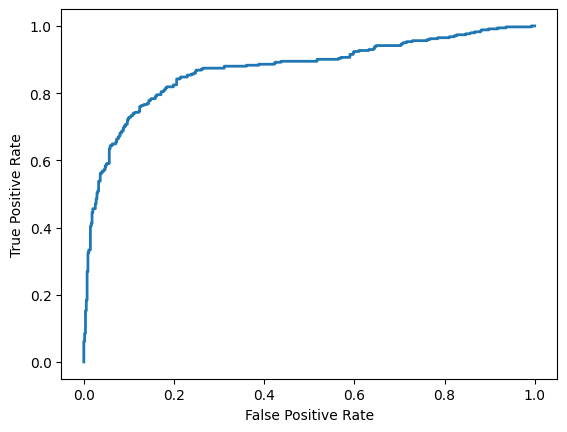

Model training and evaluation completed.


In [18]:
from sklearn.model_selection import cross_val_predict

prd_scores = cross_val_predict(model_pipeline, train_data ,train_data_target, cv=20,method='predict_proba')
print(prd_scores)
fpr, tpr, thresholds = roc_curve(train_data_target, prd_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
plot_roc_curve(fpr, tpr, label='ROC Curve')
print("Model training and evaluation completed.")

In [19]:
model_pipeline.fit(training_data, train_data_target)

test_data = read_csv('test.csv')

predict_surviving = model_pipeline.predict(test_data)
sub_data = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predict_surviving})
sub_data.to_csv('submission.csv', index=False)
print("Submission file created.")

Submission file created.
